# Project: Wrangling and Analyze Data

In [157]:
import pandas as pd
import requests
import tweepy
import re
import os
import json
from fractions import Fraction
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [158]:
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1106,734787690684657664,NaN,NaN,2016-05-23 16:46:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This dog is more successful than I will ever b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/734787690...,13,10,None,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [159]:
#  Checks if folder exists, if not creaates one
folder_name = 'image-predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [160]:
with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)

In [161]:
df_image_predictions = pd.read_csv('image-predictions/image-predictions.tsv', sep='\t')
df_image_predictions.sample()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1112,724049859469295616,https://pbs.twimg.com/media/CgxXf1TWYAEjY61.jpg,1,Border_collie,0.581835,True,collie,0.344588,True,Shetland_sheepdog,0.043584,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

Due to a delayed approval from twitter on the creation of a developer account,I have used the provided twitter_api.py and tweet_json.txt to tackle this section.<br>


In [6]:
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [40]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
tweet_ids = df_twitter_archive.tweet_id.values
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet-json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepyException as e:
            fails_dict[tweet_id] = e
            pass
end = timer()

In [162]:
tweets = []
with open('tweet-json.txt', 'r') as file:
    for line in file:
        data = json.loads(line)
        tweets.append(data)
df_twitter_api = pd.DataFrame(tweets, columns=['id', 'retweet_count', 'favorite_count'])

In [163]:
df_twitter_api.sample()

,id,retweet_count,favorite_count
1074,739606147276148736,1876,5897


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



#### Visual Assessment

In [164]:
# Loading the df_twitter_archive file to assess it visually
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [165]:
# Loading the df_image_predictions file to assess it visually
df_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [166]:
#  Loading the df_twitter_api file to assess it visually
df_twitter_api

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


#### Programmatic Assessment

In [167]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [168]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [169]:
df_twitter_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [170]:
# To assess the timestamp values of retweeted_status timestamp and determine format of values.
df_twitter_archive[df_twitter_archive['retweeted_status_timestamp'].notnull()].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None


In [171]:
# To check for duplicated column names.
all_columns = pd.Series(list(df_twitter_archive) + list(df_image_predictions) + list(df_twitter_api))
all_columns[all_columns.duplicated()]

17    tweet_id
dtype: object

In [172]:
df_twitter_archive.duplicated().sum()

0

In [173]:
df_image_predictions.duplicated().sum()

0

In [174]:
df_image_predictions[df_image_predictions['jpg_url'].duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1903,851953902622658560,https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg,1,Staffordshire_bullterrier,0.757547,True,American_Staffordshire_terrier,0.149950,True,Chesapeake_Bay_retriever,0.047523,True
1944,861769973181624320,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,2,Arabian_camel,0.366248,False,house_finch,0.209852,False,cocker_spaniel,0.046403,True
1992,873697596434513921,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
2041,885311592912609280,https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg,1,Labrador_retriever,0.908703,True,seat_belt,0.057091,False,pug,0.011933,True


In [175]:

df_image_predictions.jpg_url.value_counts()

https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg                                            2
https://pbs.twimg.com/media/Cq9guJ5WgAADfpF.jpg                                            2
https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg    2
https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg                                            2
https://pbs.twimg.com/media/CsrjryzWgAAZY00.jpg                                            2
                                                                                          ..
https://pbs.twimg.com/media/CXrmMSpUwAAdeRj.jpg                                            1
https://pbs.twimg.com/media/CXrawAhWkAAWSxC.jpg                                            1
https://pbs.twimg.com/media/CXrIntsUsAEkv0d.jpg                                            1
https://pbs.twimg.com/media/CXqcOHCUQAAugTB.jpg                                            1
https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg                       

In [176]:
df_image_predictions[df_image_predictions[['jpg_url', 'img_num', 'p1', 'p2', 'p3']].duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1903,851953902622658560,https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg,1,Staffordshire_bullterrier,0.757547,True,American_Staffordshire_terrier,0.149950,True,Chesapeake_Bay_retriever,0.047523,True
1944,861769973181624320,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,2,Arabian_camel,0.366248,False,house_finch,0.209852,False,cocker_spaniel,0.046403,True
1992,873697596434513921,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
2041,885311592912609280,https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg,1,Labrador_retriever,0.908703,True,seat_belt,0.057091,False,pug,0.011933,True


In [177]:
df_twitter_api.id.duplicated().sum()

0

In [178]:
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [179]:
df_image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [180]:
df_twitter_api.describe()

,id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


In [181]:
df_twitter_archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [182]:
df_image_predictions.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [183]:
df_twitter_api.isnull().sum()

id                0
retweet_count     0
favorite_count    0
dtype: int64

In [184]:
df_twitter_archive.tweet_id.value_counts()

892420643555336193    1
687102708889812993    1
687826841265172480    1
687818504314159109    1
687807801670897665    1
                     ..
775085132600442880    1
774757898236878852    1
774639387460112384    1
774314403806253056    1
666020888022790149    1
Name: tweet_id, Length: 2356, dtype: int64

In [185]:
df_twitter_archive[df_twitter_archive.name == 'a'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 56 to 2354
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    55 non-null     int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   55 non-null     object 
 4   source                      55 non-null     object 
 5   text                        55 non-null     object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               55 non-null     object 
 10  rating_numerator            55 non-null     int64  
 11  rating_denominator          55 non-null     int64  
 12  name                        55 non-null     object 
 13  doggo                       55 non

In [186]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [187]:
# Checks if any of the denominators is greater than 10
df_twitter_archive[df_twitter_archive.rating_denominator > 10].value_counts().sum()

0

In [188]:
# Checks if there are ratings lesser than 2
df_twitter_archive[df_twitter_archive.rating_numerator < 2].value_counts().sum()

0

In [189]:
df_twitter_archive.source.duplicated().sum()

2352

### Quality issues
#### `df_twitter_archive` table
- Missing values in variables 'in_reply_to_status_id', 'in_reply_to_user_id', 'expanded_urls', 'retweeted_status_id', 'retweeted_status_timestamp'  and 'retweeted_status_user_id'
- Erroneous datatype(timestamp and retweeted_status_timestamp columns).
- Lowercase dog names are invalide.g a, an and the represnted as dog name vlues.
- Retweets are basically the same as tweets therefore need to be dropped.
- Some columns are not useful for later analysis(in_reply_to_status_id, in_reply_to_user_id, source, text, expanded_urls, retweeted_status_id, retweeted_status_timestamp,  retweeted_status_user_id).
- Some rating numerators are invalid having rating that exceed two digits.
- Almost all values in the source column are duplicated.

#### `df_image_predictions` table
- Erroneous datatype(img_num). Should be a category since it's not to be used in any mathematical operations and contain repeated values.

### `df_twitter_api` table
- id column is not consistent with the other tables having 'tweet_id' as the column name.

### Tidiness issues
- Rating_numerator and rating_denominator should be represented as one column displaying a fraction.
- One variable in four columns in `df_twitter_archive` table(doggo, floofer, pupper and puppo)
- All columns in the `df_image_predictions` and `df_twitter_api` except for the *tweet_id* column should be part of the `df_twitter_archive` table, for they are one observational unit.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [483]:
# Make copies of original pieces of data
df_twitter_archive_clean = df_twitter_archive.copy()
df_image_predictions_clean = df_image_predictions.copy()
df_twitter_api_clean = df_twitter_api.copy()

#### Cleaning sections
- Tidiness
- Quality
 

### Issue #1: Tidiness

##### rating_numerator and rating_denominator should be represented as one column displaying a fraction

#### Define

- First extract regex expression to extract rating fraction from text and name the column pattern.
- Compare this with with the current numerator and denomitor ratings by converting them to a fraction with name Fraction column.
- replace invalid fraction values with pattern values.
- Drop the pattern column, rating numerator and rating denominator.
- assess the denominator, drop column with denominator greater than 10.
- Drop numerators with values greater than 20.
- Convert fraction column to float.

#### Code

In [484]:
regex = r'''([+-]?([0-9]+[.])?[0-9]+\/[+-]?([0-9]+[.])?[0-9]+)'''

          #[+-]?([0-9]*[.])?[0-9]+\/[+-]?([0-9]*[.])?[0-9]+
def get_pattern(pat):
  try:
      return re.findall(regex, pat)[0][0]
  except Exception as e:
      return ''


df_twitter_archive_clean['pattern'] = df_twitter_archive_clean['text'].apply(get_pattern)
df_twitter_archive_clean['fraction'] = df_twitter_archive_clean['rating_numerator'].astype(str) + '/' + df_twitter_archive_clean['rating_denominator'].astype(str)
df_twitter_archive_clean[df_twitter_archive_clean['pattern'] != df_twitter_archive_clean['fraction']][['pattern', 'fraction']]

,pattern,fraction
45,13.5/10,5/10
313,960/00,960/0
340,9.75/10,75/10
387,007/10,7/10
695,9.75/10,75/10
763,11.27/10,27/10
1689,9.5/10,5/10
1712,11.26/10,26/10
2260,-5/10,5/10


In [485]:
# Change fraction values to match those of pattern while changing those that are invalid
df_twitter_archive_clean.loc[45,'fraction']='13.5/10'
df_twitter_archive_clean.loc[313,'fraction']='9.6/10'
df_twitter_archive_clean.loc[340,'fraction']='9.75/10'
df_twitter_archive_clean.loc[695,'fraction']='9.75/10'
df_twitter_archive_clean.loc[763,'fraction']='11.27/10'
df_twitter_archive_clean.loc[1689,'fraction']='9.5/10'
df_twitter_archive_clean.loc[1712,'fraction']='11.26/10'

In [486]:
# Below values in pattern column are invalid therefore there was need to modify the fraction column in this case.
df_twitter_archive_clean[df_twitter_archive_clean['pattern'] != df_twitter_archive_clean['fraction']][['pattern', 'fraction']]

,pattern,fraction
313,960/00,9.6/10
387,007/10,7/10
2260,-5/10,5/10


In [487]:
df_twitter_archive_clean.drop(['pattern', 'rating_numerator', 'rating_denominator' ], axis=1, inplace=True)

In [488]:
# Fraction(df_twitter_archive_clean.fraction)
df_twitter_archive_clean[df_twitter_archive_clean.fraction.str.contains(r'[0-9]{3,}')]['fraction']

188      420/10
189      666/10
290      182/10
902     165/150
979     1776/10
1120    204/170
1634    143/130
1635    121/110
1779    144/120
2074     420/10
Name: fraction, dtype: object

In [489]:
# Drops the columns with invalid ratings
df_twitter_archive_clean.drop([188, 189, 290, 902, 979, 1120, 1634, 1635, 1779, 2074], axis=0, inplace=True)

In [490]:
df_twitter_archive_clean.fraction.str.contains(r'-[0-9]+').sum()

0

In [491]:
df_twitter_archive_clean[df_twitter_archive_clean.fraction.str.contains(r'[2][6-9]')]['fraction']

763     11.27/10
1712    11.26/10
Name: fraction, dtype: object

In [492]:
df_twitter_archive_clean[df_twitter_archive_clean.fraction.str.contains(r'[0-9][0-9]\/[0-9][1-9]')]['fraction']

342     11/15
1663    20/16
Name: fraction, dtype: object

In [493]:
# drop the extra invalid rows
df_twitter_archive_clean.drop([342, 1663], axis=0, inplace=True)

In [494]:
df_twitter_archive_clean[df_twitter_archive_clean.fraction.str.contains(r'[0-9][0-9]\/[0]')]['fraction']

Series([], Name: fraction, dtype: object)

In [495]:
# Converts the fraction string values to floats
df_twitter_archive_clean.fraction = df_twitter_archive_clean.fraction.apply(pd.eval)

#### Test

In [496]:
# Affirms pattern column has been dropped
# Also affrims columns with invalid ratings have been dropped
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 0 to 2355
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2344 non-null   int64  
 1   in_reply_to_status_id       72 non-null     float64
 2   in_reply_to_user_id         72 non-null     float64
 3   timestamp                   2344 non-null   object 
 4   source                      2344 non-null   object 
 5   text                        2344 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2290 non-null   object 
 10  name                        2344 non-null   object 
 11  doggo                       2344 non-null   object 
 12  floofer                     2344 non-null   object 
 13  pupper                      2344 

In [119]:
# Test that every numerator with 3 or more values is dropped, this was before converting fraction to float.
df_twitter_archive_clean.fraction.str.contains(r'[0-9]{3,}').sum()

0

In [497]:
# Affirms that all fractions have been converted to floats
df_twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,name,doggo,floofer,pupper,puppo,fraction
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,Phineas,None,None,None,None,1.3
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,Tilly,None,None,None,None,1.3
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,Archie,None,None,None,None,1.2
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,Darla,None,None,None,None,1.3
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,Franklin,None,None,None,None,1.2


In [498]:
df_twitter_archive_clean.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,name,doggo,floofer,pupper,puppo,fraction
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,None,None,None,None,None,0.5
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,a,None,None,None,None,0.6
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,a,None,None,None,None,0.9
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,a,None,None,None,None,0.7
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,None,None,None,None,None,0.8


##### One variable in four columns in df_twitter_archive table(doggo, floofer, pupper and puppo)

In [499]:
df_twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,name,doggo,floofer,pupper,puppo,fraction
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,Phineas,None,None,None,None,1.3
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,Tilly,None,None,None,None,1.3
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,Archie,None,None,None,None,1.2
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,Darla,None,None,None,None,1.3
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,Franklin,None,None,None,None,1.2


#### Define

Melt the *doggo*, *floofer*, *pupper* and *puppo* columns to a *dog_stage* column. Drop the column containing the variable names since they are represented by value names.

#### Code

In [500]:
df_twitter_archive_clean = pd.melt(df_twitter_archive_clean,
                      id_vars = ['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls', 'timestamp', 'source', 'text', 'name', 'fraction'],
                           var_name = 'type', value_name ='dog_stage', value_vars = ['doggo', 'floofer', 'pupper', 'puppo'])

df_twitter_archive_clean = df_twitter_archive_clean .drop('type', axis=1)

#### Test

In [501]:
df_twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,timestamp,source,text,name,fraction,dog_stage
0,892420643555336193,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,Phineas,1.3,None
1,892177421306343426,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,Tilly,1.3,None
2,891815181378084864,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,Archie,1.2,None
3,891689557279858688,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,Darla,1.3,None
4,891327558926688256,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,Franklin,1.2,None


#### All columns in the df_image_predictions and df_twitter_api except for the tweet_id column should be part of the df_twitter_archive table, for they are one observational unit.

#### Define

Merge the df_twitter_api_clean columns and df_image_predictions_clean columns to the df_twitter_archive_clean table, joining on tweet_id column.<br>
First convert id column in df_twitter_api to tweet_id.

#### Code

In [502]:
df_twitter_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [503]:
# renaming to tweet_id
df_twitter_api_clean.rename(columns = {'id':'tweet_id'}, inplace=True)

In [504]:
df_tweets = pd.merge(pd.merge(df_twitter_archive_clean, df_image_predictions_clean, on='tweet_id', how='inner'), df_twitter_api_clean, on='tweet_id', how='inner')

#### Test

In [505]:
# Confirm id column in df_twitter_api table now reads tweet_id
df_twitter_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [506]:
df_tweets.shape

(8264, 26)

In [507]:
df_tweets.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,timestamp,source,text,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
1,892420643555336193,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
2,892420643555336193,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
3,892420643555336193,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
4,892177421306343426,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6514,33819


In [508]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8264 entries, 0 to 8263
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    8264 non-null   int64  
 1   in_reply_to_status_id       88 non-null     float64
 2   in_reply_to_user_id         88 non-null     float64
 3   retweeted_status_id         316 non-null    float64
 4   retweeted_status_user_id    316 non-null    float64
 5   retweeted_status_timestamp  316 non-null    object 
 6   expanded_urls               8264 non-null   object 
 7   timestamp                   8264 non-null   object 
 8   source                      8264 non-null   object 
 9   text                        8264 non-null   object 
 10  name                        8264 non-null   object 
 11  fraction                    8264 non-null   float64
 12  dog_stage                   8264 non-null   object 
 13  jpg_url                     8264 

In [509]:
df_tweets.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,timestamp,source,text,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
8259,666029285002620928,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,...,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,48,132
8260,666020888022790149,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,...,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,532,2535
8261,666020888022790149,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,...,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,532,2535
8262,666020888022790149,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,...,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,532,2535
8263,666020888022790149,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,...,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,532,2535


### Issue #3: Quality Issues

##### Missing values in variables 'in_reply_to_status_id', 'in_reply_to_user_id', 'expanded_urls', 'retweeted_status_id', 'retweeted_status_timestamp' and 'retweeted_status_user_id'

In the course of cleaning my missing data I will have to deal with the data issue:
#####  Retweets are basically the same as tweets therefore need to be dropped

In [510]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8264 entries, 0 to 8263
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    8264 non-null   int64  
 1   in_reply_to_status_id       88 non-null     float64
 2   in_reply_to_user_id         88 non-null     float64
 3   retweeted_status_id         316 non-null    float64
 4   retweeted_status_user_id    316 non-null    float64
 5   retweeted_status_timestamp  316 non-null    object 
 6   expanded_urls               8264 non-null   object 
 7   timestamp                   8264 non-null   object 
 8   source                      8264 non-null   object 
 9   text                        8264 non-null   object 
 10  name                        8264 non-null   object 
 11  fraction                    8264 non-null   float64
 12  dog_stage                   8264 non-null   object 
 13  jpg_url                     8264 

#### Define

Drop the rows with retweets having notnull values.

#### Code

In [511]:
# drop rows notnull retweet rows since they have have values > 0
df_tweets.drop(df_tweets[df_tweets['retweeted_status_id'] >= 0.0].index, inplace=True)

#### Test

In [512]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7948 entries, 0 to 8263
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    7948 non-null   int64  
 1   in_reply_to_status_id       88 non-null     float64
 2   in_reply_to_user_id         88 non-null     float64
 3   retweeted_status_id         0 non-null      float64
 4   retweeted_status_user_id    0 non-null      float64
 5   retweeted_status_timestamp  0 non-null      object 
 6   expanded_urls               7948 non-null   object 
 7   timestamp                   7948 non-null   object 
 8   source                      7948 non-null   object 
 9   text                        7948 non-null   object 
 10  name                        7948 non-null   object 
 11  fraction                    7948 non-null   float64
 12  dog_stage                   7948 non-null   object 
 13  jpg_url                     7948 

##### Some columns are not useful for later analysis(in_reply_to_status_id, in_reply_to_user_id, source, text, expanded_urls, retweeted_status_id, retweeted_status_timestamp, 'jpg_url',  retweeted_status_user_id)

#### Define: 

Drop the columns. This solves the missing values issues, the eroneous data type for  `retweeted_status_timestamp` and duplicate source column values.

#### Code

In [513]:
df_tweets.shape

(7948, 26)

In [514]:
df_tweets.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,timestamp,source,text,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
1,892420643555336193,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
2,892420643555336193,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
3,892420643555336193,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
4,892177421306343426,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6514,33819


In [515]:
# Drops the columns with the missing values
col_drops = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls', 'source', 'text', 'jpg_url']
df_tweets.drop(col_drops, axis=1, inplace=True)

#### Test

In [516]:
df_tweets.shape

(7948, 17)

In [517]:
# tests that the dropped columns are no longer present
df_tweets.head()

,tweet_id,timestamp,name,fraction,dog_stage,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56 +0000,Phineas,1.3,None,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
1,892420643555336193,2017-08-01 16:23:56 +0000,Phineas,1.3,None,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
2,892420643555336193,2017-08-01 16:23:56 +0000,Phineas,1.3,None,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
3,892420643555336193,2017-08-01 16:23:56 +0000,Phineas,1.3,None,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
4,892177421306343426,2017-08-01 00:17:27 +0000,Tilly,1.3,None,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6514,33819


In [518]:
# Affirms that all columns with missing values have been dropped
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7948 entries, 0 to 8263
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        7948 non-null   int64  
 1   timestamp       7948 non-null   object 
 2   name            7948 non-null   object 
 3   fraction        7948 non-null   float64
 4   dog_stage       7948 non-null   object 
 5   img_num         7948 non-null   int64  
 6   p1              7948 non-null   object 
 7   p1_conf         7948 non-null   float64
 8   p1_dog          7948 non-null   bool   
 9   p2              7948 non-null   object 
 10  p2_conf         7948 non-null   float64
 11  p2_dog          7948 non-null   bool   
 12  p3              7948 non-null   object 
 13  p3_conf         7948 non-null   float64
 14  p3_dog          7948 non-null   bool   
 15  retweet_count   7948 non-null   int64  
 16  favorite_count  7948 non-null   int64  
dtypes: bool(3), float64(4), int64(4),

#### Duplicate columns in df_tweets

In [519]:
df_tweets.duplicated().sum()

5644

#### Define

Drop the duplicate values in df_tweets.

#### Code

In [520]:
df_tweets = df_tweets.drop_duplicates()

#### Test

In [521]:
df_tweets.shape

(2304, 17)

#### Lower case dog names in the name column are invalid

#### Define

Replace all lowercase dog names with value None

#### Code

In [522]:
df_tweets.loc[df_tweets.name.str.islower()].head()

,tweet_id,timestamp,name,fraction,dog_stage,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
84,887517139158093824,2017-07-19 03:39:09 +0000,such,1.4,None,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False,12082,46959
200,881536004380872706,2017-07-02 15:32:16 +0000,a,1.4,None,1,Samoyed,0.281463,True,Angora,0.272066,False,Persian_cat,0.114854,False,16570,50199
202,881536004380872706,2017-07-02 15:32:16 +0000,a,1.4,pupper,1,Samoyed,0.281463,True,Angora,0.272066,False,Persian_cat,0.114854,False,16570,50199
564,859196978902773760,2017-05-02 00:04:57 +0000,quite,1.2,None,1,Angora,0.224218,False,malamute,0.216163,True,Persian_cat,0.128383,False,25661,75193
620,855459453768019968,2017-04-21 16:33:22 +0000,quite,1.2,None,2,Blenheim_spaniel,0.389513,True,Pekinese,0.188220,True,Japanese_spaniel,0.082628,True,8987,31657


In [523]:
# replace all lower case names with nulls
df_tweets.name.mask(df_tweets.name.str.match(r'^[a-z]+$'), inplace=True)

In [536]:
df_tweets.name = df_tweets.name.fillna('None')

#### Test

In [540]:
# Affirms lowercase names are non existent
df_tweets.name.str.islower().sum()

0

In [541]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2304 entries, 0 to 8260
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        2304 non-null   int64  
 1   timestamp       2304 non-null   object 
 2   name            2304 non-null   object 
 3   fraction        2304 non-null   float64
 4   dog_stage       2304 non-null   object 
 5   img_num         2304 non-null   int64  
 6   p1              2304 non-null   object 
 7   p1_conf         2304 non-null   float64
 8   p1_dog          2304 non-null   bool   
 9   p2              2304 non-null   object 
 10  p2_conf         2304 non-null   float64
 11  p2_dog          2304 non-null   bool   
 12  p3              2304 non-null   object 
 13  p3_conf         2304 non-null   float64
 14  p3_dog          2304 non-null   bool   
 15  retweet_count   2304 non-null   int64  
 16  favorite_count  2304 non-null   int64  
dtypes: bool(3), float64(4), int64(4),

In [544]:
df_tweets.name[df_tweets.name == 'None'].value_counts()

None    774
Name: name, dtype: int64

#### Erroneous datatype(img_num). Should be a category since it's not to be used in any mathematical operations and contain repeated values and Erroneous datatype(timestamp column)

In [545]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2304 entries, 0 to 8260
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        2304 non-null   int64  
 1   timestamp       2304 non-null   object 
 2   name            2304 non-null   object 
 3   fraction        2304 non-null   float64
 4   dog_stage       2304 non-null   object 
 5   img_num         2304 non-null   int64  
 6   p1              2304 non-null   object 
 7   p1_conf         2304 non-null   float64
 8   p1_dog          2304 non-null   bool   
 9   p2              2304 non-null   object 
 10  p2_conf         2304 non-null   float64
 11  p2_dog          2304 non-null   bool   
 12  p3              2304 non-null   object 
 13  p3_conf         2304 non-null   float64
 14  p3_dog          2304 non-null   bool   
 15  retweet_count   2304 non-null   int64  
 16  favorite_count  2304 non-null   int64  
dtypes: bool(3), float64(4), int64(4),

#### Define

Convert `img_num` to a categorical datatype. Convert `timestamp` to datetime datatype

#### Code

In [546]:
df_tweets.img_num = df_tweets.img_num.astype('category')
df_tweets.timestamp = pd.to_datetime(df_tweets.timestamp)

#### Test

In [547]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2304 entries, 0 to 8260
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        2304 non-null   int64              
 1   timestamp       2304 non-null   datetime64[ns, UTC]
 2   name            2304 non-null   object             
 3   fraction        2304 non-null   float64            
 4   dog_stage       2304 non-null   object             
 5   img_num         2304 non-null   category           
 6   p1              2304 non-null   object             
 7   p1_conf         2304 non-null   float64            
 8   p1_dog          2304 non-null   bool               
 9   p2              2304 non-null   object             
 10  p2_conf         2304 non-null   float64            
 11  p2_dog          2304 non-null   bool               
 12  p3              2304 non-null   object             
 13  p3_conf         2304 non-null   f

#### Define

rename fraction column to rating

#### Code

In [582]:
df_tweets.rename(columns = {'fraction':'rating'}, inplace=True)

#### Test

In [584]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2304 entries, 0 to 8260
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        2304 non-null   int64              
 1   timestamp       2304 non-null   datetime64[ns, UTC]
 2   name            2304 non-null   object             
 3   rating          2304 non-null   float64            
 4   dog_stage       2304 non-null   object             
 5   img_num         2304 non-null   category           
 6   p1              2304 non-null   object             
 7   p1_conf         2304 non-null   float64            
 8   p1_dog          2304 non-null   bool               
 9   p2              2304 non-null   object             
 10  p2_conf         2304 non-null   float64            
 11  p2_dog          2304 non-null   bool               
 12  p3              2304 non-null   object             
 13  p3_conf         2304 non-null   f

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [585]:
df_tweets.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [586]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2304 entries, 0 to 8260
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        2304 non-null   int64              
 1   timestamp       2304 non-null   datetime64[ns, UTC]
 2   name            2304 non-null   object             
 3   rating          2304 non-null   float64            
 4   dog_stage       2304 non-null   object             
 5   img_num         2304 non-null   category           
 6   p1              2304 non-null   object             
 7   p1_conf         2304 non-null   float64            
 8   p1_dog          2304 non-null   bool               
 9   p2              2304 non-null   object             
 10  p2_conf         2304 non-null   float64            
 11  p2_dog          2304 non-null   bool               
 12  p3              2304 non-null   object             
 13  p3_conf         2304 non-null   f

In [588]:
# Evaluate average dog_stage ratings
df_tweets.groupby('dog_stage')['rating'].mean()

dog_stage
None       1.055592
doggo      1.178378
floofer    1.187500
pupper     1.065222
puppo      1.204348
Name: rating, dtype: float64

In [589]:
# Evaluates percentage of false dog breed predictions
false1=df_tweets.p1_dog.value_counts(normalize=True).mul(100)[False]

In [590]:
# Evaluates percentage of false dog breed predictions
false2=df_tweets.p2_dog.value_counts(normalize=True).mul(100)[False]

In [591]:
# Evaluates percentage of false dog breed predictions
false3=df_tweets.p3_dog.value_counts(normalize=True).mul(100)[False]

In [592]:
mean_percentage_false_breeds = (false1 + false2 + false3)/3
mean_percentage_false_breeds

25.911458333333332

In [593]:
df_tweets.dog_stage.value_counts()

None       1987
pupper      212
doggo        74
puppo        23
floofer       8
Name: dog_stage, dtype: int64

In [594]:
average_pupper_rating = df_tweets.groupby('dog_stage')['rating'].mean()['pupper']
average_doggo_rating = df_tweets.groupby('dog_stage')['rating'].mean()['doggo']
average_puppo_rating = df_tweets.groupby('dog_stage')['rating'].mean()['puppo']
average_floofer_rating = df_tweets.groupby('dog_stage')['rating'].mean()['puppo']

In [595]:
pupper_ratings = average_pupper_rating * df_tweets['dog_stage'].value_counts()['pupper']
doggo_ratings = average_doggo_rating * df_tweets['dog_stage'].value_counts()['doggo']
puppo_ratings = average_puppo_rating * df_tweets['dog_stage'].value_counts()['puppo']
floofer_ratings = average_floofer_rating * df_tweets['dog_stage'].value_counts()['floofer']

In [596]:
pupper_ratings

225.82699999999997

In [597]:
doggo_ratings

87.2

In [598]:
puppo_ratings

27.7

In [599]:
floofer_ratings

9.634782608695652

In [600]:
#  individual average favorite count for the dog stages
df_tweets.groupby('dog_stage')['favorite_count'].mean()

dog_stage
None        8910.966281
doggo      18881.932432
floofer    13701.375000
pupper      7424.240566
puppo      22723.913043
Name: favorite_count, dtype: float64

### Insights:
1. The dog_stage floofer has the highest average rating with pupper having the lowest.

2. Averagely 25.9% of the dog predictions are not dog breeds.

3. Most of the dogs are in the pupper stage.

4. In comparison to the number of dogs in each dog stage, the puppers have the highest ratings.

5. The doggo have most favorite counts with pupper having the least.


### Visualization

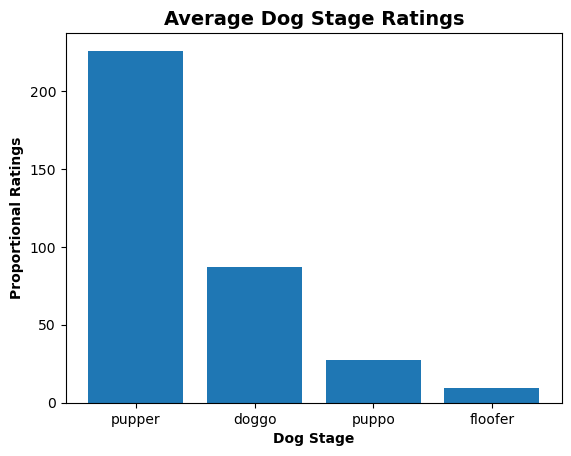

In [601]:
plt.bar(['pupper', 'doggo', 'puppo', 'floofer'], [pupper_ratings, doggo_ratings, puppo_ratings, floofer_ratings])
plt.title('Average Dog Stage Ratings', fontsize=14, weight='bold')
plt.xlabel('Dog Stage', fontsize=10, weight='bold')
plt.ylabel('Proportional Ratings', fontsize=10, weight='bold');